In [1]:
import cv2
import glob
import numpy as np

vehicle_imgs = [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in glob.glob('data/vehicles/*/*.png')]
non_vehicle_imgs =[cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in glob.glob('data/non-vehicles/*/*.png')]

In [2]:
from features.histogram_feature_extractor import HistogramFeatureExtractor
from features.pooled_pixel_feature_extractor import PooledPixelFeatureExtractor
from features.feature_concatenator import FeatureConcatenator
from features.hog_feature_extractor import HogFeatureExtractor
from preprocess.preprocessor import Preprocessor

preprocessor = Preprocessor()

histogram_extractor = HistogramFeatureExtractor()
pooled_pixel_extractor = PooledPixelFeatureExtractor()
hog_feature_extractor = HogFeatureExtractor()
feature_concatenator = FeatureConcatenator([histogram_extractor, hog_feature_extractor, pooled_pixel_extractor])

from sklearn.preprocessing import StandardScaler

def extract_features(images):
    preprocessed = preprocessor.process(images)
    features = np.vstack([feature_concatenator.extract(img) for img in preprocessed]).astype(np.float64)
    return features

In [3]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

features = np.vstack([extract_features(vehicle_imgs), extract_features(non_vehicle_imgs)])
labels = np.hstack([np.ones(len(vehicle_imgs)), np.zeros(len(non_vehicle_imgs))])
scaler = StandardScaler().fit(features)
pickle.dump(scaler, open('scaler.bin', 'wb'))

scaled_features = scaler.transform(features)

scaled_features, labels = shuffle(scaled_features, labels)

train_features, test_features, train_labels, test_labels = train_test_split(
    scaled_features, labels, test_size=0.2)

In [4]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

#clf = SVC()
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#clf = GridSearchCV(clf, parameters)
#print(clf.best_params_)

clf = SVC(kernel='rbf', C=10.0)
clf.fit(train_features, train_labels)
pickle.dump(clf, open('model.bin', 'wb'))

In [5]:
pred = clf.predict(test_features)
print(accuracy_score(test_labels, pred))

0.993243243243


In [6]:
import pickle

# Load saved model
model = pickle.load(open('model.bin', 'rb'))
# Load saved scaler
scaler = pickle.load(open('scaler.bin', 'rb'))

In [7]:
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

from detection.vehicle_detector import VehicleDetector
import sys
sys.path.append("../advanced_lane_finding")
from lane_detection_pipeline import LaneDetector

vehicle_detector = VehicleDetector(model, scaler)
lane_detector = LaneDetector('../advanced_lane_finding/camera_cal/*.jpg')

def detect_lanes_and_vehicles(img, filter_context=None, detection_context=None):
    vehicle_detected = vehicle_detector.add_detection(img, detection_context)
    lanes = lane_detector.detect_lanes(img, filter_context)
    return cv2.addWeighted(vehicle_detected, 1.0, lanes, 0.4, 0.0)

test_imgs = [detect_lanes_and_vehicles(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)) \
             for image_path in glob.glob('test_images/*.jpg')]

def display_imgs(imgs, rows, cols, figsize=(20, 10), cmap='gray'):
    plt.figure(figsize=figsize)
    idx = 1
    for img in imgs:
        plt.subplot(rows, cols, idx)
        plt.imshow(img, cmap=cmap)
        idx += 1

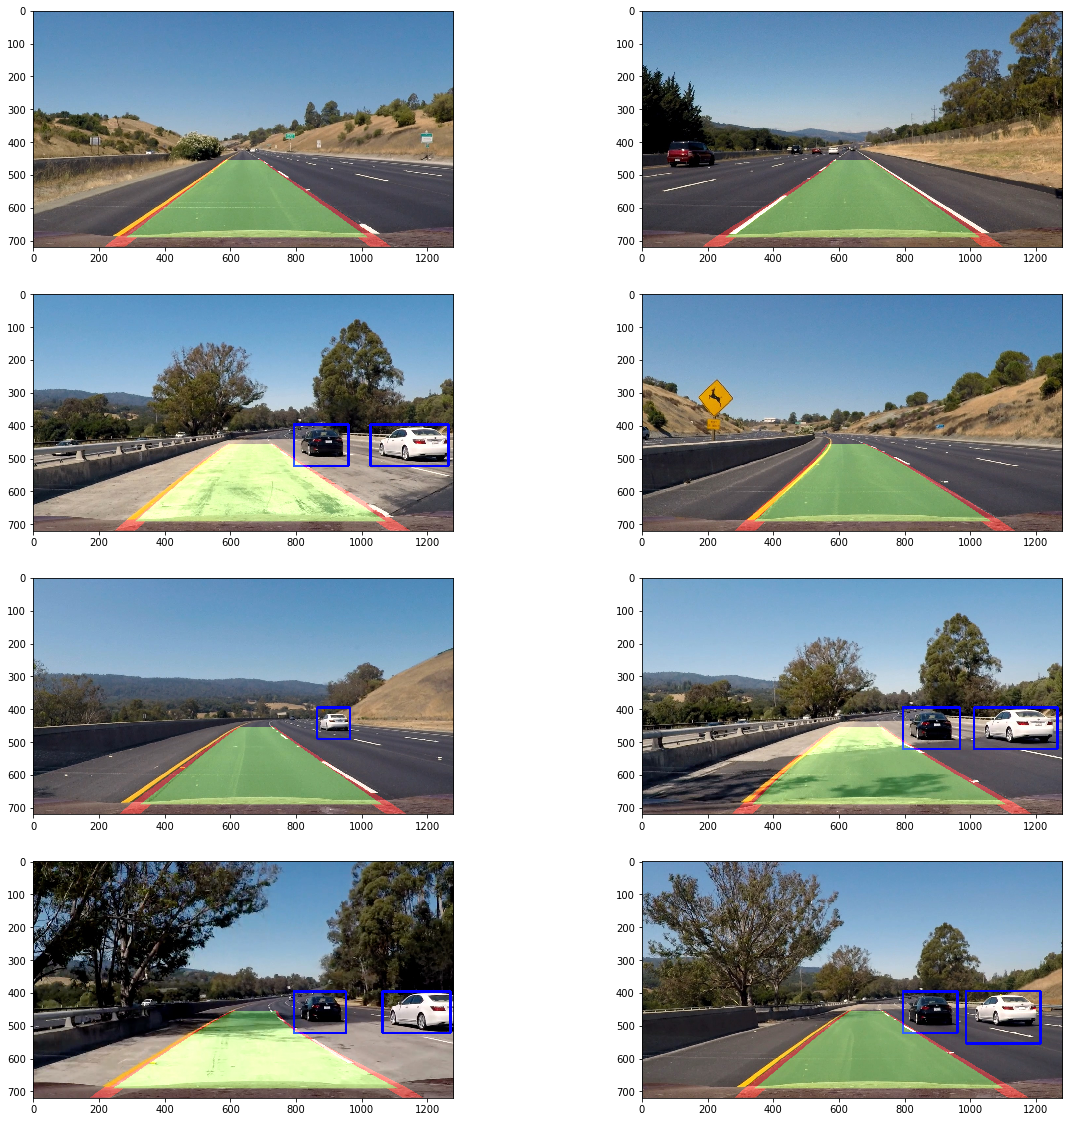

In [8]:
display_imgs(test_imgs, 4, 2, figsize=(20, 20))

In [9]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from detection.detection_context import DetectionContext
from filters.filter_context import FilterContext

project_video_output = 'output/project_video.mp4'
project_video_clip = VideoFileClip("./project_video.mp4")
detection_context = DetectionContext()
filter_context = FilterContext()
project_video_clip = project_video_clip.fl_image(lambda img : detect_lanes_and_vehicles(
    img, filter_context, detection_context))
%time project_video_clip.write_videofile(project_video_output, audio=False)


HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

[MoviePy] >>>> Building video output/project_video.mp4
[MoviePy] Writing video output/project_video.mp4


100%|█████████▉| 1260/1261 [53:00<00:02,  2.56s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video.mp4 

CPU times: user 2h 57min 59s, sys: 9min 3s, total: 3h 7min 2s
Wall time: 53min 1s
